# Análisis de datos de AFP Modelo
En este notebook se analiza el comportamiento de los fondos de pensiones de la AFP Modelo, para ello se compara el comportamiento de los fondos (A, B, C, D, y E) y se compara a través del último mes.

Primero se importan los datos desde la página de la AFP utilizando **`urllib3`**
<!-- Sería interesante encontrar una base de datos más completa y con mayor proyecciones (modelo funciona desde ~2009) -->

In [1]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
html = urllib3.PoolManager().request('GET', 'https://www.afpmodelo.cl/AFP/Indicadores/Valor-Cuota.aspx')


Se lee utilizando la librería **`BeautifulSoup`** para extraer los datos en HTML, es necesario formatear los datos, ya que vienen como strings.

In [2]:
from bs4 import BeautifulSoup
from datetime import datetime

soup = BeautifulSoup(html.data, 'html.parser')

def currency_format(string_currency): # '$ 40.850,20' -> 40850.2
    new_format = string_currency.replace('$','').replace('.','').replace(',','.').strip()
    try:
        result = float(new_format)
    except:
        result = new_format
    return result

fecha = []
A,B,C,D,E = [],[],[],[],[]

table = soup.find("table")
for row in table.findAll("tr"):
    cells = row.findAll("td")
    if len(cells) == 6:
        fecha.append( datetime.strptime(cells[0].find(text=True),'%d-%m-%Y') )
        A.append(currency_format(cells[1].find(text=True)))
        B.append(currency_format(cells[2].find(text=True)))
        C.append(currency_format(cells[3].find(text=True)))
        D.append(currency_format(cells[4].find(text=True)))
        E.append(currency_format(cells[5].find(text=True)))


Es posible visualizar la evolución de los fondos simplemente ploteando en función de fecha

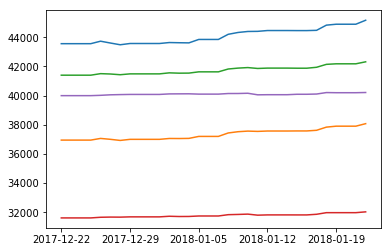

In [3]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.plot(fecha,A);
plt.plot(fecha,B);
plt.plot(fecha,C);
plt.plot(fecha,D);
plt.plot(fecha,E);

Para generar una idea de la relación entre los distintos fondos, se puede generar un histograma que compara los datos, esto es posible gracias a las librerías **`numpy`** y **`pandas`** que ayudan a organizar la información.

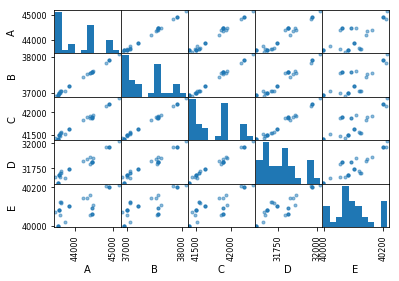

In [4]:
import numpy as np
import pandas as pd

fondos = np.array([A,B,C,D,E]).transpose()

df = pd.DataFrame(fondos, index=fecha, columns=list('ABCDE'))
#print(df)

pd.scatter_matrix(df);

Se puede observar una clara relación entre los fondos A y B, y entre los fondos B y C, lo que hace pensar que las rentabilidades de dichos fondos (más riesgosos) están dadas por factores comunes y su diferencia radica sólo en el porcentaje de inversión realizado, y no en el tipo de inversión.

## Comparación entre AFPs
Los precios de los 5 fondos para todas las afps en el mercado pueden ser encontrados en la superintendencia de pensiones.

https://www.spensiones.cl/safpstats/stats/

Importar data de cada fondo en un arreglo

In [5]:
AFPs   = ['CAPITAL', 'CUPRUM', 'HABITAT', 'MODELO', 'PLANVITAL', 'PROVIDA']
fondos = ['A', 'B', 'C', 'D', 'E']
url_fondo = 'https://www.spensiones.cl/safpstats/stats/apps/vcuofon/vcfAFP.php?tf={}'

datas = []
for fondo in fondos:
    html_fondo = urllib3.PoolManager().request('GET',url_fondo.format(fondo));
    datas.append( BeautifulSoup(html_fondo.data, 'html.parser') );

In [6]:
for i in range(len(datas)):
    tables = datas[i].findAll("table")
    fecha = datas[i].findAll("td", attrs={"class":"EPIGRAFE"})[1].find(text=True)
    
    print('\n')
    print('Fondo {} {}'.format(fondos[i], fecha))
    print('{:8}\t{:8}\t{:6}'.format('AFP','Valor Cuota','Total Fondo'))
    
    AFP_count = 0
    for table in tables:
        for row in table.findAll("tr"):
            if AFP_count == 5: break
            cells = row.findAll("td")
            if cells[0].find(text=True) in AFPs:
                AFP_count += 1
                afp = cells[0].find(text=True)
                cuota = currency_format(cells[1].find(text=True))
                total = currency_format(cells[2].find(text=True))
                print( '{:8}\t{:8}\t{:6.2}'.format(afp, cuota, total))




Fondo A 23-Enero-2018
       
AFP     	Valor Cuota	Total Fondo
CAPITAL 	43505.91	4.2e+12
CUPRUM  	45984.83	5.5e+12
HABITAT 	--      	--    
MODELO  	45273.49	1.5e+12
PLANVITAL	 42485.6	5.2e+11


Fondo B 23-Enero-2018
       
AFP     	Valor Cuota	Total Fondo
CAPITAL 	37873.16	4.2e+12
CUPRUM  	39724.84	3.9e+12
HABITAT 	--      	--    
MODELO  	38121.98	2.3e+12
PLANVITAL	37804.11	9.7e+11


Fondo C 23-Enero-2018
       
AFP     	Valor Cuota	Total Fondo
CAPITAL 	37728.21	8.8e+12
CUPRUM  	44305.93	8.9e+12
HABITAT 	--      	--    
MODELO  	42341.67	1.4e+12
PLANVITAL	76318.65	1.5e+12


Fondo D 23-Enero-2018
       
AFP     	Valor Cuota	Total Fondo
CAPITAL 	31266.54	4.6e+12
CUPRUM  	33082.92	3.3e+12
HABITAT 	--      	--    
MODELO  	32023.77	4.4e+11
PLANVITAL	 30428.4	8.3e+11


Fondo E 23-Enero-2018
       
AFP     	Valor Cuota	Total Fondo
CAPITAL 	37908.31	3.4e+12
CUPRUM  	39852.49	4.1e+12
HABITAT 	--      	--    
MODELO  	40218.46	1.1e+12
PLANVITAL	62117.15	6.8e+11


## Data histórica de AFPs

Buscar todas las AFPs disponibles en la base de datos del fondo A

In [7]:
A_file = open('originales/vcfA2002-2017.csv','r').read().split('\n')
AFPs = []

for line in A_file:
    line_array = line.split(';')
    if len(line_array) == 1 or 'Valor Cuota' in line_array: continue
    if 'Fecha' in line_array:
        AFP_olis = line_array
        new_list = []
        new_list[:] = filter(None, AFP_olis)
        new_list[:] = set(new_list) - set(['Fecha'])
        AFPs[:] = set(AFPs)|set(new_list)
print(AFPs)

['BANSANDER', 'MODELO', 'MAGISTER', 'HABITAT', 'SANTA MARIA', 'PLANVITAL', 'PROVIDA', 'CAPITAL', 'CUPRUM', 'SUMMA BANSANDER']


Definir una función para extraer los valores de cuotas y ingresando el nombre de la AFP

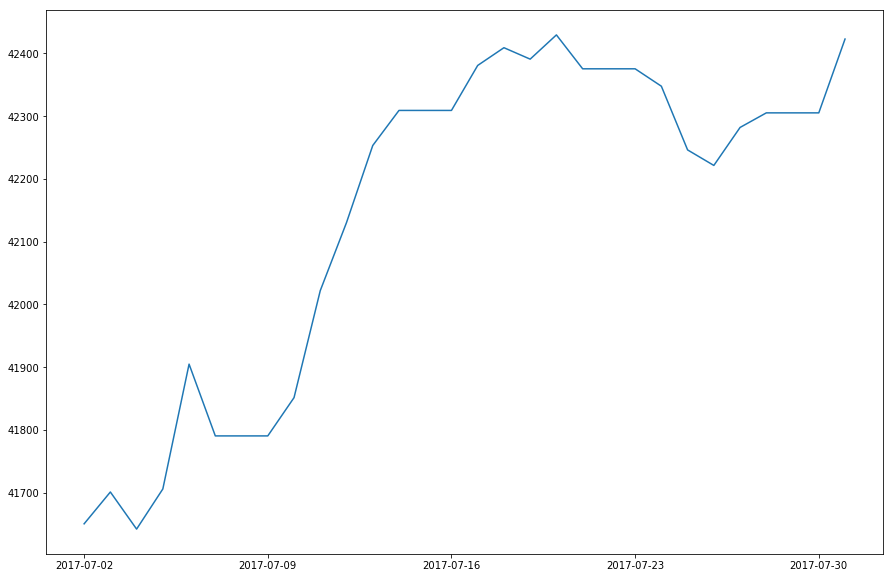

In [10]:
def extraer_datos(nombre_AFP):
    fecha = []
    cuota = []
    patrm = []
    var = []
    for line in A_file:
        line_array = line.split(';')
        if len(line_array) == 1 or 'Valor Cuota' in line_array: continue
        if 'Fecha' in line_array:
            AFP_olis = line_array
        else:
            if nombre_AFP in AFP_olis:
                i = AFP_olis.index(nombre_AFP)
                fecha.append(datetime.strptime(line_array[0], '%Y-%m-%d'))
                cuota.append(currency_format(line_array[i]))
                patrm.append(currency_format(line_array[i+1]))
    var = (np.array(cuota)[:-1]-np.array(cuota)[1:])/np.array(cuota)[:-1]
    return fecha, np.array(cuota), np.array(patrm), var


plt.rcParams["figure.figsize"] = [15,10]
#for afp_it in AFPs[:1]:
#    fechas, mod_cuota, mod_pat, var = extraer_datos(afp_it)
#    plt.plot(fechas[1:], var)

fechas, mod_cuota, mod_pat, var = extraer_datos('MODELO')
plt.plot(fechas[-30:], mod_cuota[-30:])